# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [1]:
from helpers import get_dumps, display_dumps

PROTOCOLS = ["scp", "hpn-scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

dumps = get_dumps(PROTOCOLS, N)
df, ids = display_dumps(dumps)
df

,Protocol,Batch ID,Start Time,File Size (bytes),Bytes Down,Bytes Up,Bytes Total,Ratio (%),Time (s),Speed (bytes/s)
0,ftp,1,2015-09-27 17:30:48,2106924,2113729,7501,2121230,100.68,15.79,133865.04
1,ftp,0,2015-09-27 17:28:16,6,3317,4069,7386,123100.00,4.84,685.33
2,gridftp,1,2015-09-27 17:31:21,2106924,2110873,4145,2115018,100.38,14.81,142530.25
3,gridftp,0,2015-09-27 17:28:29,6,3927,4145,8072,134533.33,4.93,796.55
4,hpn-scp,1,2015-09-27 17:31:06,2106924,2112201,4023,2116224,100.44,13.67,154513.61
5,hpn-scp,0,2015-09-27 17:28:23,6,2789,3447,6236,103933.33,3.72,749.73
6,scp,1,2015-09-27 17:31:38,2106924,2111577,4081,2115658,100.41,13.72,153905.03
7,scp,0,2015-09-27 17:28:36,6,2717,3633,6350,105833.33,3.60,754.72


## Aggregated Data
The table above can be aggregated per filesize and protocol, then displayed visually.

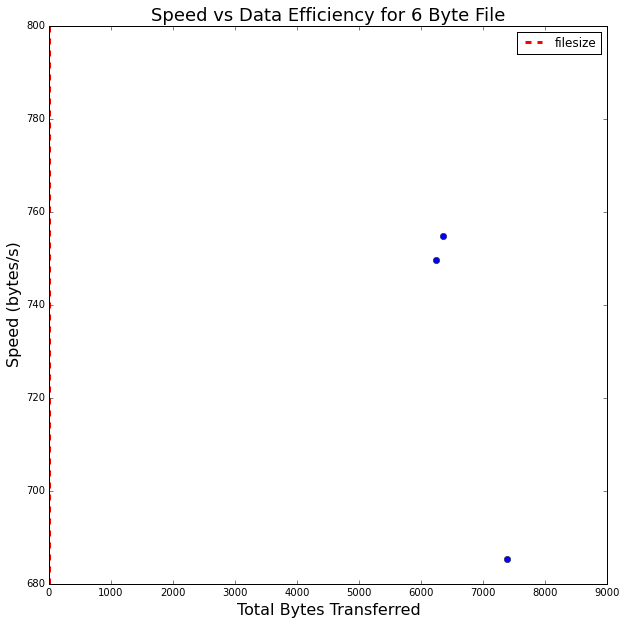

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from ipywidgets import interact, fixed

from helpers import plot_speed_efficiency

rcParams['figure.figsize'] = (10, 10)

# TODO: Aggregate by protocol, per filesize

sizes = {str(x):x for x in set(df["File Size (bytes)"])}
agg_interact = interact(plot_speed_efficiency, df=fixed(df), filesize=sizes)


## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

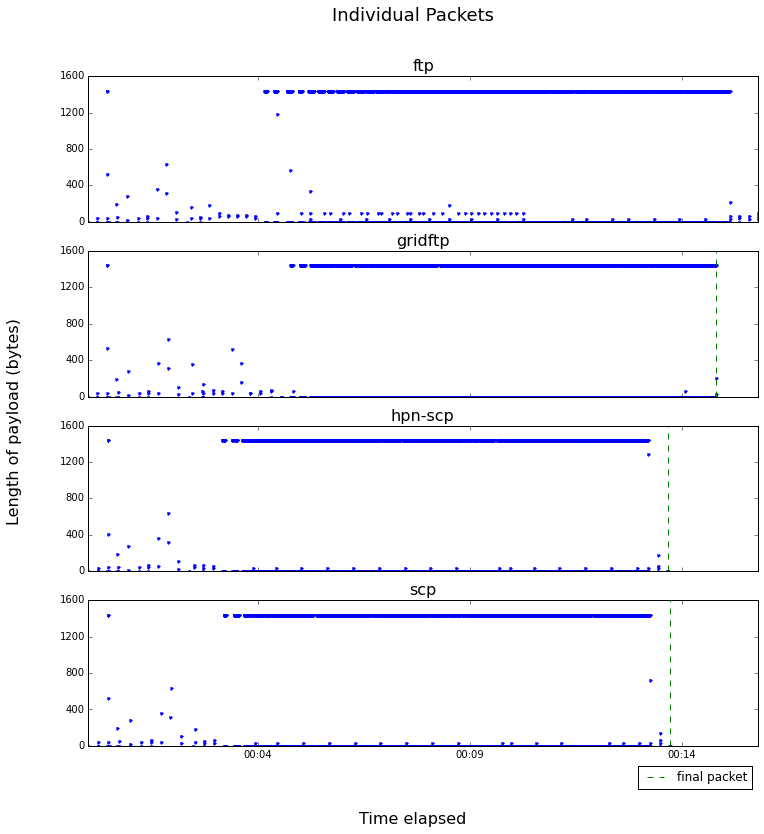

In [3]:
%matplotlib inline
from helpers import plot_packets
import warnings

warnings.simplefilter('ignore', UserWarning)
rcParams['figure.figsize'] = (12, 12)

dump_batches = {}
for bid in set(df["Batch ID"]):
    dump_batches[str(bid)] = [dump for dump in dumps if ids[dump["batch_id"]] == bid]

packet_interact = interact(plot_packets, dump_batch=dump_batches)